# Libs and pre-definitions

### Bibliotecas padrões python e utils pytorch

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from collections import defaultdict
from torch.utils.data import random_split
import copy

In [2]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [3]:
import NN_models as models
import uncertainty.comparison as unc_comp
import uncertainty.quantifications as unc
import uncertainty.losses as losses
import uncertainty.train_and_eval_with_g as TE_g
import NN_utils as utils
import NN_utils.train_and_eval as TE

## Data download and transforms

In [4]:
transforms_train = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
transforms_test = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [5]:
training_data = datasets.CIFAR10(
root="data",
 train=True,
 download=True,
transform=transforms_train)

test_data = datasets.CIFAR10(
root="data",
train=False,
download=True,
transform=transforms_test)

train_size = int(0.85*len(training_data))
val_size = len(training_data) - train_size
training_data, validation_data = random_split(training_data, [train_size, val_size])

validation_data = copy.deepcopy(validation_data)
validation_data.dataset.transform = transforms_test

Files already downloaded and verified
Files already downloaded and verified


In [6]:
batch_size = 100
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size,shuffle = False)
test_dataloader = DataLoader(test_data, batch_size=100)

# Train classifier

In [7]:
loss_criterion = nn.NLLLoss(reduction = 'none')

loss_fn = losses.selective_net_2(loss_criterion,const_var = 'g')
from torch.nn.functional import softmax
def SM_fn(g,lamb = 1, dim = -1):
    lamb = torch.as_tensor(lamb)
    w = softmax(lamb*g,dim=dim)
    return w

risk_dict = {'empirical_risk':losses.selective_net_2(loss_criterion,optim_method = None,head = None,alpha = 1),
             'bce_risk':lambda x,label: torch.mean(loss_criterion(x[0],label)),
             'constraint':lambda x,label: loss_fn.get_constraint(x[1]),
             'selective_risk_g':lambda x,label: unc_comp.selective_risk(x,label,unc_type = 'g'),
            'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x[0],label,unc_type = unc.MCP_unc)}

In [8]:
#model with auxiliary head 'h' defined paralell to the classifier.
#model_h = transform_in_selective_vgg(models.Model_CNN_with_g_and_h(10,blocks = main_layer)).cuda()
model_h = models.Model_CNN_with_g_and_h(10).cuda()
optimizer = torch.optim.SGD(model_h.parameters(), lr=1e-3,momentum = 0.9)
loss_criterion = nn.NLLLoss(reduction = 'none')
loss_fn = losses.selective_net_2(loss_criterion,w_fn = SM_fn,head = model_h.get_h,alpha = 0.5,c_fn = losses.entropy_const,const_var = 'w')

model_trainer_h = TE_g.Trainer_with_g(model_h,optimizer,loss_fn, train_dataloader,validation_dataloader,c=0.8,risk_dict = risk_dict)
model_trainer_h.fit(train_dataloader,1000)
#state_dict  = model_h.state_dict()

model_h.return_g = False
acc = TE.model_acc(model_h,train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(model_h,test_dataloader)
print('Conjunto de teste: acc = ', acc)

Epoch  1 , loss =  2.17150092012742
Epoch  2 , loss =  1.9470754578534295
Epoch  3 , loss =  1.7999410915374756
Epoch  4 , loss =  1.6890497566671931
Epoch  5 , loss =  1.5996624556709738
Epoch  6 , loss =  1.5324487400054931
Epoch  7 , loss =  1.4738547165253584
Epoch  8 , loss =  1.429028187639573
Epoch  9 , loss =  1.3955864684722004
Epoch  10 , loss =  1.3654607859779806
Epoch  11 , loss =  1.334074156705071
Epoch  12 , loss =  1.3001771632362815
Epoch  13 , loss =  1.2751409917719223
Epoch  14 , loss =  1.252908592785106
Epoch  15 , loss =  1.2269202545109916
Epoch  16 , loss =  1.1998457295754377
Epoch  17 , loss =  1.1778433778706718
Epoch  18 , loss =  1.1474719659019919
Epoch  19 , loss =  1.1272992840935203
Epoch  20 , loss =  1.1067946610731236
Epoch  21 , loss =  1.0817889976501465
Epoch  22 , loss =  1.0638447422139785
Epoch  23 , loss =  1.0493349827037137
Epoch  24 , loss =  1.0335309000576243
Epoch  25 , loss =  1.0215006501534405
Epoch  26 , loss =  1.0058276336333332


In [9]:
#model with auxiliary head as the main classifier
#model_f = transform_in_selective_vgg(models.Model_CNN_with_g(10,blocks = main_layer)).cuda()
model_f = models.Model_CNN_with_g(10).cuda()
optimizer = torch.optim.SGD(model_f.parameters(), lr=1e-3,momentum = 0.9)
loss_criterion = nn.NLLLoss(reduction = 'none')
loss_fn = losses.selective_net_2(loss_criterion,w_fn = SM_fn,head = 'y',alpha = 0.5,c_fn = losses.entropy_const,const_var = 'w')

model_trainer_f = TE_g.Trainer_with_g(model_f,optimizer,loss_fn, train_dataloader,validation_dataloader,c=0.8,risk_dict = risk_dict)
model_trainer_f.fit(train_dataloader,1000)
#state_dict  = model_h.state_dict()

model_f.return_g = False
acc = TE.model_acc(model_f,train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(model_f,test_dataloader)
print('Conjunto de teste: acc = ', acc)

Epoch  1 , loss =  2.1306935986350566
Epoch  2 , loss =  1.8812736011953914
Epoch  3 , loss =  1.7189718294143677
Epoch  4 , loss =  1.602718955488766
Epoch  5 , loss =  1.5272042336183436
Epoch  6 , loss =  1.4719326181972727
Epoch  7 , loss =  1.4302096630545222
Epoch  8 , loss =  1.3914036546033972
Epoch  9 , loss =  1.3653315704009112
Epoch  10 , loss =  1.3348672718160293
Epoch  11 , loss =  1.3068427363563986
Epoch  12 , loss =  1.2833075868382173
Epoch  13 , loss =  1.2555515666568982
Epoch  14 , loss =  1.2363944206518285
Epoch  15 , loss =  1.2068780403978685
Epoch  16 , loss =  1.1876758997580585
Epoch  17 , loss =  1.1648612117767334
Epoch  18 , loss =  1.1403856165268842
Epoch  19 , loss =  1.127311439934899
Epoch  20 , loss =  1.1072874243119184
Epoch  21 , loss =  1.087391998347114
Epoch  22 , loss =  1.0676525030416602
Epoch  23 , loss =  1.0502919056836297
Epoch  24 , loss =  1.0306758605732638
Epoch  25 , loss =  1.0153775617655585
Epoch  26 , loss =  1.005036485195159

In [10]:
#model with auxiliary head as the main classifier
model_nohead = models.Model_CNN_with_g(10).cuda()
#model_nohead = transform_in_selective_vgg(models.Model_CNN_with_g(10,blocks = main_layer)).cuda()
optimizer = torch.optim.SGD(model_nohead.parameters(), lr=1e-3,momentum = 0.9,weight_decay = 5e-4)
loss_criterion = nn.NLLLoss(reduction = 'none')
loss_fn = losses.selective_net_2(loss_criterion,w_fn = SM_fn,c_fn = losses.entropy_const,const_var = 'w')

model_trainer_nohead = TE_g.Trainer_with_g(model_nohead,optimizer,loss_fn, train_dataloader,validation_dataloader,c=0.8,risk_dict = risk_dict)
model_trainer_nohead.fit(train_dataloader,1000)
#state_dict  = model_h.state_dict()

model_nohead.return_g = False
acc = TE.model_acc(model_nohead,train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(model_nohead,test_dataloader)
print('Conjunto de teste: acc = ', acc)

Epoch  1 , loss =  2.0983925611832563
Epoch  2 , loss =  1.8152100184384514
Epoch  3 , loss =  1.6406143541897045
Epoch  4 , loss =  1.5230048625609454
Epoch  5 , loss =  1.445518289453843
Epoch  6 , loss =  1.390816678720362
Epoch  7 , loss =  1.337777777559617
Epoch  8 , loss =  1.3038639444463394
Epoch  9 , loss =  1.2666569235745597
Epoch  10 , loss =  1.2270459615483003
Epoch  11 , loss =  1.193678133347455
Epoch  12 , loss =  1.1601831781162935
Epoch  13 , loss =  1.1293143645454855
Epoch  14 , loss =  1.0998614553844228
Epoch  15 , loss =  1.0746895945773405
Epoch  16 , loss =  1.0532541673323688
Epoch  17 , loss =  1.027915557272294
Epoch  18 , loss =  1.0087886451272403
Epoch  19 , loss =  0.9876101993112003
Epoch  20 , loss =  0.973356817890616
Epoch  21 , loss =  0.9581186789624832
Epoch  22 , loss =  0.9366374656733345
Epoch  23 , loss =  0.9293576689327464
Epoch  24 , loss =  0.9215548964107738
Epoch  25 , loss =  0.8956366769005271
Epoch  26 , loss =  0.8892208938037648
E

# Save models

In [15]:
import pickle
PATH = r'/home/luis-felipe/Uncertainty_Estimation/torch_models'
PATH_trainer = r'/home/luis-felipe/Uncertainty_Estimation/torch_models/trainer'
SUFIX = '_softmax_entropy'

model_trainer_h.hist_val.loss_criterion = None
model_trainer_h.hist_val.risk_dict = None
model_trainer_h.hist_train.loss_criterion = None
model_trainer_h.hist_train.risk_dict = None

model_trainer_f.hist_train.loss_criterion = None
model_trainer_f.hist_train.risk_dict = None
model_trainer_f.hist_val.loss_criterion = None
model_trainer_f.hist_val.risk_dict = None

model_trainer_nohead.hist_train.loss_criterion = None
model_trainer_nohead.hist_train.risk_dict = None
model_trainer_nohead.hist_val.loss_criterion = None
model_trainer_nohead.hist_val.risk_dict = None


torch.save(model_h.state_dict(), PATH + '/selective_h' + SUFIX)
with open(PATH_trainer + r"/hist_val_h_trainer"+SUFIX, "wb") as output_file:
    pickle.dump(model_trainer_h.hist_val,output_file)
with open(PATH_trainer + r"/hist_train_h_trainer"+SUFIX, "wb") as output_file:
    pickle.dump(model_trainer_h.hist_train,output_file)
    
torch.save(model_f.state_dict(), PATH + '/selective_f'+SUFIX)
with open(PATH_trainer + r"/hist_train_f_trainer"+SUFIX, "wb") as output_file:
    pickle.dump(model_trainer_f.hist_train,output_file)
with open(PATH_trainer + r"/hist_val_f_trainer"+SUFIX, "wb") as output_file:
    pickle.dump(model_trainer_f.hist_val,output_file)
    
torch.save(model_nohead.state_dict(), PATH + '/selective_nohead'+SUFIX)
with open(PATH_trainer + r"/hist_train_nohead_trainer"+SUFIX, "wb") as output_file:
    pickle.dump(model_trainer_nohead.hist_train,output_file)
with open(PATH_trainer + r"/hist_val_nohead_trainer"+SUFIX, "wb") as output_file:
    pickle.dump(model_trainer_nohead.hist_val,output_file)

# Plots

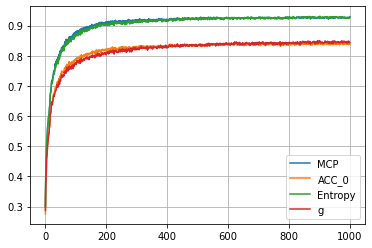

In [12]:
plt.plot(model_trainer_h.hist_val.acc_c_mcp,label = 'MCP')
plt.plot(model_trainer_h.hist_val.acc_list,label = 'ACC_0')
plt.plot(model_trainer_h.hist_val.acc_c_entropy,label = 'Entropy')
plt.plot(model_trainer_h.hist_val.acc_c_g, label = 'g')
plt.grid()
plt.legend()
plt.show()

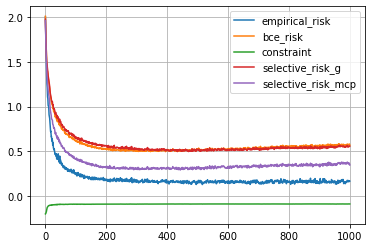

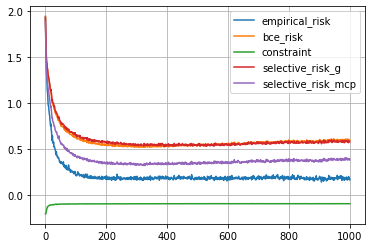

In [13]:
for key in risk_dict:
    plt.plot(model_trainer_h.hist_val.risk[key],label = key)

plt.grid()
plt.legend()
plt.show()

for key in risk_dict:
    plt.plot(model_trainer_f.hist_val.risk[key],label = key)

plt.grid()
plt.legend()
plt.show()